In [1]:
!pip install tensorflow soundfile

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import soundfile as sf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
import ast

# Clone TensorFlow models repository (for VGGish)
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 90080, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 90080 (delta 61), reused 100 (delta 50), pack-reused 89967
Receiving objects: 100% (90080/90080), 606.62 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (64889/64889), done.


In [2]:
%cd models/research/audioset/vggish

/content/models/research/audioset/vggish


In [3]:
# Download VGGish model checkpoints
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  65.6M      0  0:00:04  0:00:04 --:--:-- 65.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   171k      0 --:--:-- --:--:-- --:--:--  171k


In [4]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.8 MB/s eta 0:00:00


In [5]:
# Import VGGish after changing directory
import vggish_params
import vggish_input
import vggish_slim

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/MLProject/songs-balanced-final.csv')
df['merged_labels'] = df['merged_labels'].apply(ast.literal_eval)

# Define all genres and moods
all_genres = ['electronic', 'rock', 'funk&soul', 'pop', 'folk&country', 'hiphop', 'rhythm&blues', 'jazz']
all_moods = ['happy/celebration/party/dance', 'loss/sad/heartbreak/angst/protest', 'romantic/love/passion/devotion', 'motivating/inspirational/uplifting/confidence/nostalgia']

# Binarize labels
mlb = MultiLabelBinarizer(classes=all_genres + all_moods)
df['labels'] = list(mlb.fit_transform(df['merged_labels']))

import os
for index, sample in df.iterrows():
  file_path = sample["file_path"]
  if not os.path.isfile(file_path):
        df = df.drop(index)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


In [8]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1290, 5)
(323, 5)
(404, 5)


In [9]:
def preprocess_audio(file_path, sr=16000):
    # Load a specific part of the audio file (from 1:00 to 1:30 min)
    wav_data, sr = sf.read(file_path)
    #assert wav_data.dtype == np.int16, 'Bad sample type: %r' % wav_data.dtype
    samples = wav_data / 32768.0  # Convert to [-1.0, +1.0]
    # Compute log mel spectrogram features
    log_mel = vggish_input.waveform_to_examples(samples, sr)

    return log_mel

def data_generator(df, batch_size=32):
    while True:
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df))
            df_batch = df[start:end]
            for _, row in df_batch.iterrows():
                file_path = row['file_path']
                labels = row['labels']
                spectrogram = preprocess_audio(file_path)

                x_batch.append(spectrogram)
                y_batch.append(labels)
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [10]:
# Define VGGish model
def load_vggish():
    with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, 'vggish_model.ckpt')

        features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

        return sess, features_tensor, embedding_tensor

sess, features_tensor, embedding_tensor = load_vggish()


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


In [12]:
from tensorflow.keras.optimizers import Adam

def build_model(num_classes):
    model = tf.keras.Sequential()

    # Convolutional Layer 1
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(31, 96, 64)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    # Convolutional Layer 2
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    # Convolutional Layer 3
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    # Flatten layer
    model.add(tf.keras.layers.Flatten())

    # Dense Layer 1
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())

    # Dense Layer 2
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())

    # Output Layer
    model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

    return model


num_classes = len(all_genres) + len(all_moods)
model = build_model(num_classes)
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Assuming 'model' is your compiled Keras model
optimizer = model.optimizer
print("Learning Rate:", optimizer.learning_rate.numpy())


def exact_match_accuracy(true_labels, predictions):
    exact_match = np.all(true_labels == predictions, axis=1)
    ema_accuracy = np.mean(exact_match)
    genre_true, mood_true = true_labels[:, :8], true_labels[:, 8:]
    genre_pred, mood_pred = predictions[:, :8], predictions[:, 8:]
    exact_match_genre = np.all(genre_true == genre_pred, axis=1)
    exact_match_mood = np.all(mood_true == mood_pred, axis=1)
    exact_match_genres = np.mean(exact_match_genre)
    exact_match_moods = np.mean(exact_match_mood)

    return ema_accuracy, exact_match_genres, exact_match_moods


Learning Rate: 0.001


In [13]:
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, train_df, val_df, epochs=15, batch_size=32, threshold=0.5):
    train_gen = data_generator(train_df, batch_size)
    val_gen = data_generator(val_df, batch_size)

    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size
    if len(val_df) % batch_size != 0:
        validation_steps += 1  # To include the last smaller batch

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    model_save_dir = '/content/saved_models/'

    for epoch in range(epochs):
        print(epoch)
        history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=1)
        train_losses.append(history.history['loss'][0])
        val_loss, val_accuracy = model.evaluate(val_gen, steps=validation_steps)
        val_losses.append(val_loss)

        # Resetting the validation generator
        val_gen = data_generator(val_df, batch_size)
        val_preds = model.predict(val_gen, steps=validation_steps)

        # Convert probabilities to binary values
        val_preds_binary = (val_preds > threshold).astype(int)

        # Truncate the labels to match the number of predictions
        val_labels = np.array(val_df['labels'].tolist())[:len(val_preds_binary)]

        # Save the model at each epoch
        model_save_path = os.path.join(model_save_dir, f'model_epoch_{epoch + 1}.h5')
        model.save_weights(model_save_path)

        # Custom metrics
        f1 = f1_score(val_labels, val_preds_binary, average='micro')
        precision = precision_score(val_labels, val_preds_binary, average='micro')
        recall = recall_score(val_labels, val_preds_binary, average='micro')
        hamming = hamming_loss(val_labels, val_preds_binary)
        ema_accuracy, exact_match_genres, exact_match_moods = exact_match_accuracy(val_labels, val_preds_binary)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f" - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
        print(f" - F1 Score: {f1:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f}")
        print(f" - Hamming Loss: {hamming:.4f}")
        print(f" - Exact Match Accuracy: {ema_accuracy:.4f}")
        print(f" - Exact Match Genres: {exact_match_genres:.4f} - Exact Match Moods: {exact_match_moods:.4f}")

    print(train_losses, val_losses)

# Train and evaluate the model
train_and_evaluate_model(model, train_df, val_df)
# 200


0
11/11 [==============================] - 26s 3s/step
Epoch 1/15
 - val_loss: 1.5946 - val_accuracy: 0.1734
 - F1 Score: 0.1957 - Precision: 0.2198 - Recall: 0.1764
 - Hamming Loss: 0.3011
 - Exact Match Accuracy: 0.0000
 - Exact Match Genres: 0.0186 - Exact Match Moods: 0.0000
1
11/11 [==============================] - 27s 3s/step
Epoch 2/15
 - val_loss: 1.1045 - val_accuracy: 0.1734
 - F1 Score: 0.1365 - Precision: 0.2384 - Recall: 0.0957
 - Hamming Loss: 0.2513
 - Exact Match Accuracy: 0.0000
 - Exact Match Genres: 0.1734 - Exact Match Moods: 0.0000
2
11/11 [==============================] - 29s 3s/step
Epoch 3/15
 - val_loss: 1.3274 - val_accuracy: 0.1734
 - F1 Score: 0.2660 - Precision: 0.2988 - Recall: 0.2398
 - Hamming Loss: 0.2748
 - Exact Match Accuracy: 0.0124
 - Exact Match Genres: 0.1734 - Exact Match Moods: 0.3591
3
11/11 [==============================] - 28s 3s/step
Epoch 4/15
 - val_loss: 1.5857 - val_accuracy: 0.1734
 - F1 Score: 0.1365 - Precision: 0.2384 - Recall: 0

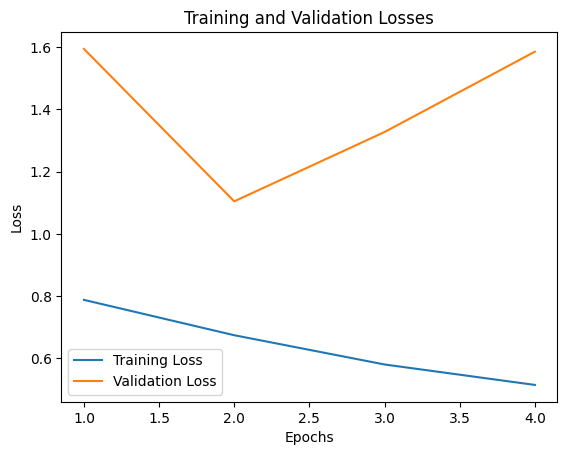

In [19]:
# Plotting the training and validation losses
plt.plot(range(1, epochs + 1), train_losses[0:4], label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses[0:4], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [20]:
model_load_path = os.path.join('/content/saved_models/', f'model_epoch_3.h5')
model.load_weights(model_load_path)
print(f"Loaded checkpoint from epoch 3")
print(model)

Loaded checkpoint from epoch 3


In [22]:
test_gen = data_generator(test_df, batch_size=32)

In [23]:
validation_steps = len(test_df) // 32
if len(test_df) % 32 != 0:
      validation_steps += 1  # To include the last smaller batch

In [25]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=validation_steps)

# Resetting the validation generator
test_preds = model.predict(test_gen, steps=validation_steps)

# Convert probabilities to binary values
test_preds_binary = (test_preds > 0.5).astype(int)

# Truncate the labels to match the number of predictions
test_labels = np.array(test_df['labels'].tolist())[:len(test_preds_binary)]


# Custom metrics
f1 = f1_score(test_labels, test_preds_binary, average='micro')
precision = precision_score(test_labels, test_preds_binary, average='micro')
recall = recall_score(test_labels, test_preds_binary, average='micro')
hamming = hamming_loss(test_labels, test_preds_binary)
ema_accuracy, exact_match_genres, exact_match_moods = exact_match_accuracy(test_labels, test_preds_binary)

print(f" - val_loss: {test_loss:.4f} - val_accuracy: {test_accuracy:.4f}")
print(f" - F1 Score: {f1:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f}")
print(f" - Hamming Loss: {hamming:.4f}")
print(f" - Exact Match Accuracy: {ema_accuracy:.4f}")
print(f" - Exact Match Genres: {exact_match_genres:.4f} - Exact Match Moods: {exact_match_moods:.4f}")



13/13 [==============================] - 36s 3s/step
 - val_loss: 1.3194 - val_accuracy: 0.1708
 - F1 Score: 0.2327 - Precision: 0.2562 - Recall: 0.2132
 - Hamming Loss: 0.2816
 - Exact Match Accuracy: 0.0223
 - Exact Match Genres: 0.1708 - Exact Match Moods: 0.2970
